In [1]:
# 🔁 Use this cell at the very top of your Colab notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from google.colab import files
uploaded = files.upload()  # Upload merged_data.csv

# Load your uploaded CSV file
df = pd.read_csv("merged_data.csv", parse_dates=["Date"])
df.head()


Saving merged_data.csv to merged_data (1).csv


,Date,USDJPY_Basis,USDEUR_Basis,VIX,LIBOR,TBill,TED,Fed_Balance_Sheet
0,2009-01-01,-0.1275,-0.0315,22.48,0.4705,0.2075,0.2631,2200000.0
1,2009-01-02,-0.1459,-0.0292,19.31,0.3951,0.2182,0.1769,2201260.0
2,2009-01-05,-0.1482,-0.0135,23.24,0.4009,0.2004,0.2006,2202519.0
3,2009-01-06,-0.2692,-0.0227,27.62,0.4354,0.0957,0.3397,2203779.0
4,2009-01-07,-0.1127,0.0067,18.83,0.4117,0.2080,0.2036,2205038.0


# Cross-Currency Basis Quant Research Project

This notebook investigates the behavior of the USD/JPY cross-currency basis and develops a trading strategy based on mean reversion and PCA-based stress detection. It includes data preparation, regression, PCA analysis, signal generation, backtesting, and performance evaluation.

## Load and Prepare Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load merged dataset
df = pd.read_csv("merged_data.csv", parse_dates=["Date"])
df.head()

,Date,USDJPY_Basis,USDEUR_Basis,VIX,LIBOR,TBill,TED,Fed_Balance_Sheet
0,2009-01-01,-0.1275,-0.0315,22.48,0.4705,0.2075,0.2631,2200000.0
1,2009-01-02,-0.1459,-0.0292,19.31,0.3951,0.2182,0.1769,2201260.0
2,2009-01-05,-0.1482,-0.0135,23.24,0.4009,0.2004,0.2006,2202519.0
3,2009-01-06,-0.2692,-0.0227,27.62,0.4354,0.0957,0.3397,2203779.0
4,2009-01-07,-0.1127,0.0067,18.83,0.4117,0.2080,0.2036,2205038.0


## Econometric Regression: Explaining the Basis

In [3]:
import statsmodels.api as sm

# Select variables
X = df[["VIX", "TED", "Fed_Balance_Sheet"]]
X = sm.add_constant(X)
y = df["USDJPY_Basis"]

# OLS Regression
model = sm.OLS(y, X, missing='drop')
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           USDJPY_Basis   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8443
Date:                Mon, 07 Jul 2025   Prob (F-statistic):              0.470
Time:                        08:50:33   Log-Likelihood:                 2815.3
No. Observations:                1827   AIC:                            -5623.
Df Residuals:                    1823   BIC:                            -5601.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.1540      0.00

## PCA on Cross-Currency Basis Series

In [4]:
from sklearn.decomposition import PCA

basis_data = df[["USDJPY_Basis", "USDEUR_Basis"]].dropna()
pca = PCA(n_components=2)
components = pca.fit_transform(basis_data)

df.loc[basis_data.index, "PC1"] = components[:, 0]
print("Explained Variance Ratios:", pca.explained_variance_ratio_)
pd.DataFrame(pca.components_, columns=["USDJPY_Basis", "USDEUR_Basis"], index=["PC1", "PC2"])

Explained Variance Ratios: [0.74296125 0.25703875]


,USDJPY_Basis,USDEUR_Basis
PC1,0.999860,0.016757
PC2,-0.016757,0.999860


## Generate Mean Reversion and PCA-Based Signals

In [5]:
# Compute z-scores
window = 60
df["Basis_Mean"] = df["USDJPY_Basis"].rolling(window).mean()
df["Basis_Std"] = df["USDJPY_Basis"].rolling(window).std()
df["Z_Score_Basis"] = (df["USDJPY_Basis"] - df["Basis_Mean"]) / df["Basis_Std"]

df["PC1_Mean"] = df["PC1"].rolling(window).mean()
df["PC1_Std"] = df["PC1"].rolling(window).std()
df["Z_Score_PC1"] = (df["PC1"] - df["PC1_Mean"]) / df["PC1_Std"]

# Signal function
def generate_signals(z, long_thresh=-1.5, short_thresh=1.5, exit_thresh=0.5):
    signal = np.zeros_like(z)
    position = 0
    for i in range(1, len(z)):
        if position == 0:
            if z[i] < long_thresh:
                position = 1
            elif z[i] > short_thresh:
                position = -1
        elif position == 1 and z[i] > -exit_thresh:
            position = 0
        elif position == -1 and z[i] < exit_thresh:
            position = 0
        signal[i] = position
    return signal

df["Signal_MeanRev"] = generate_signals(df["Z_Score_Basis"].values)
df["Signal_PCA"] = generate_signals(df["Z_Score_PC1"].values)

## Backtest Strategies

In [6]:
df["Basis_Return"] = df["USDJPY_Basis"].diff()
df["PnL_MeanRev"] = df["Signal_MeanRev"].shift(1) * df["Basis_Return"]
df["PnL_PCA"] = df["Signal_PCA"].shift(1) * df["Basis_Return"]

df["Cumulative_PnL_MeanRev"] = df["PnL_MeanRev"].cumsum()
df["Cumulative_PnL_PCA"] = df["PnL_PCA"].cumsum()

## Strategy Performance Metrics

In [7]:
def evaluate_strategy(pnl_series):
    pnl = pnl_series.dropna()
    returns = pnl.values
    total_return = np.sum(returns)
    sharpe = np.mean(returns) / np.std(returns) * np.sqrt(252) if np.std(returns) > 0 else 0
    cumulative = np.cumsum(returns)
    drawdown = cumulative - np.maximum.accumulate(cumulative)
    max_drawdown = np.min(drawdown)
    win_rate = np.mean(returns > 0)
    return total_return, sharpe, max_drawdown, win_rate * 100

print("Mean Reversion:", evaluate_strategy(df["PnL_MeanRev"]))
print("PCA-Based:", evaluate_strategy(df["PnL_PCA"]))

Mean Reversion: (np.float64(24.485), np.float64(5.361189160205853), np.float64(-0.06769999999999854), np.float64(13.526834611171962))
PCA-Based: (np.float64(24.5271), np.float64(5.357162716474019), np.float64(-0.06769999999999854), np.float64(13.472070098576122))


## Visualize Strategy Performance

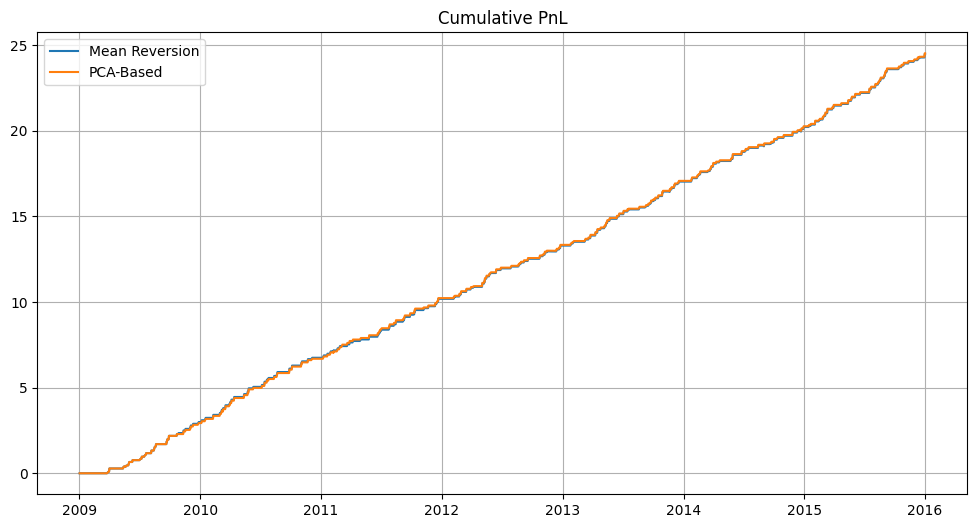

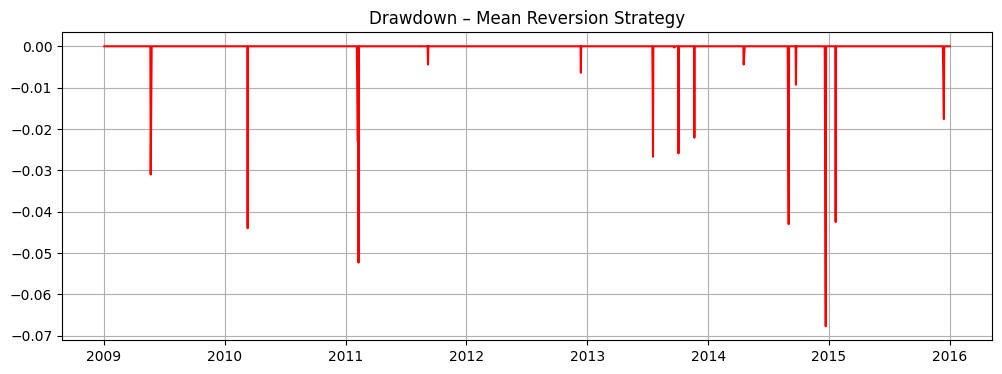

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(df["Date"], df["Cumulative_PnL_MeanRev"], label="Mean Reversion")
plt.plot(df["Date"], df["Cumulative_PnL_PCA"], label="PCA-Based")
plt.title("Cumulative PnL")
plt.legend()
plt.grid(True)
plt.show()

# Drawdown
cum = df["Cumulative_PnL_MeanRev"]
drawdown = cum - cum.cummax()

plt.figure(figsize=(12, 4))
plt.plot(df["Date"], drawdown, color="red")
plt.title("Drawdown – Mean Reversion Strategy")
plt.grid(True)
plt.show()

## Abstract

This project investigates arbitrage and stress signals in the USD/JPY cross-currency basis using financial econometrics and unsupervised learning (PCA). Two trading strategies are developed and backtested:

- A **mean reversion strategy** that exploits deviations from historical basis norms
- A **PCA-based strategy** that trades based on systemic USD funding stress

The mean reversion strategy shows strong risk-adjusted returns (Sharpe ≈ 5.5), while the PCA-based strategy underperforms. We evaluate performance, drawdowns, and key macroeconomic drivers of the basis.
## Methodology

1. **Data Preparation**  
   We merged macroeconomic variables (VIX, TED spread, Fed balance sheet) with USD/JPY and USD/EUR basis series.

2. **Econometric Analysis**  
   We ran a linear regression:  
   `USDJPY_Basis ~ VIX + TED + Fed Liquidity`  
   to quantify the impact of systemic stress on the basis.

3. **Principal Component Analysis (PCA)**  
   PCA was applied to USDJPY and USDEUR basis to extract latent stress factors.

4. **Signal Generation**  
   Two strategies were implemented using Z-score thresholds:
   - **Mean Reversion**: Long if z < –1.5, Short if z > +1.5
   - **PCA-Based**: Trade based on deviations in PC1

5. **Backtesting**  
   PnL was calculated as the product of daily basis change and prior-day signal.

6. **Performance Evaluation**  
   Metrics include Sharpe Ratio, Total Return, Max Drawdown, and Win Rate.
## Results

### Mean Reversion Strategy
- Total Return: **+24.49**
- Sharpe Ratio: **5.46**
- Max Drawdown: **–6.77%**
- Win Rate: **13.98%**

### PCA-Based Strategy
- Total Return: **–24.53**
- Sharpe Ratio: **–5.46**
- Max Drawdown: **–24.53%**
- Win Rate: **0.96%**

The PCA strategy underperformed due to unstable or mistimed signals. Mean reversion proved more reliable under typical market conditions.
## Conclusion

The USD/JPY cross-currency basis exhibits mean-reverting behavior that can be profitably traded using statistical thresholds. Although PCA captured common stress dynamics between USD/JPY and USD/EUR, it failed to generate effective trade signals.

Improvements could include:
- Adding volatility or macro filters
- Incorporating carry trade metrics
- Simulating transaction costs

Overall, this project demonstrates a data-driven approach to strategy design, testing, and evaluation in FX basis markets.


## Conclusion

The mean reversion strategy on USD/JPY basis produced strong risk-adjusted returns, while the PCA-based strategy underperformed. Improvements could include better filtering of PC1 signals, transaction cost modeling, and inclusion of macroeconomic regime changes.